## 3-1. 카메라 스티커앱 만들기 첫걸음

**하려고 하는 것**
* 카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근 의 기술을 다룹니다  
* 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 까지 만들 수 있습니다.

**학습 목표**
* 얼굴인식 카메라의 흐름을 이해
* dlib 라이브러리 사용
* 이미지 배열의 인덱싱 예외 처리
* 준비물

## 3-2. 어떻게 만들까? 사진 준비하기

* 랜드마크 = 조정 alignment : 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것  
*  keypoint detection : 조금 더 큰범위의 랜드마크를 부르는 말  

* 진행순서  
1) 얼굴이 포함된 사진을 준비하고  
2) 사진으로부터 얼굴 영역 face landmark 를 찾아냅니다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야합니다.)  
3) 찾아진 영역으로 부터 머리에 왕관 스티커를 붙여넣겠습니다.  

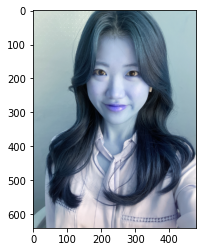

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480,640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

얼굴 색에 왜이렇게 푸른빛이 나오지?  
matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용  
opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용  
=> 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력  
그래서 이를 보정해주는 처리를 해야함  

opencv는 아주 강력하고 방대한 기능을 갖춘 컴퓨터 비전 라이브러리  
관련 업계 표준 라이브러리의 지위를 가짐 

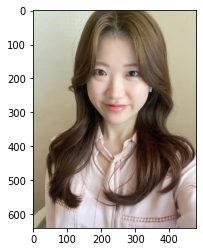

In [3]:
# 색 보정 (BRG-> RGB)
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html <-읽어보고 정리하기
openCV로 이미지 다루기
1) openCV모듈을 import  
2) cv2.imread() 함수를 이용하여 이미지 파일을 읽습니다  
이미지 파일의 경로는 절대/상대경로가 가능합니다.
>코드예시  img = cv2.imread('lena.jpg', cv2.IMREAD_COLOR)  
#cv2.imread(fileName, flag)  
#파라미터 : fileName (str) – 이미지파일의 경로,  
flag (int) – 이미지 파일을 읽을 때의 Option  
#Returns: image객체 행렬
#Return type:numpy.ndarray 

3)flag종류  
* cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.  -> 1
* cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다. -> 0 
* cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.->-1
* 각 숫자를 대신 사용해도 됨  

4) 이미지 보기  
cv2.imshow() 함수는 이미지를 사이즈에 맞게 보여줍니다.
>c22.imshow('image', img)  
#cv2.imshow(title, image)

## 3-3. 얼굴 검출 face detection :알아보자 얼굴의 위치를 찾아보자
https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c
dlib 의 face detector는  
HOG(Histogram of Oriented Gradient) feature를 사용해서  
SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다.

이제껏 
독립된 문제를 해결하기 위해 기계학습을 사용함  
(기존 데이터 기반으로 새로운 데이터 생성,  
특정 이미지에 특정 객체 있는지 확인 등)   
이건 하나의 기계학습 알고리즘을 선택하고,  
데이터를 제공해서 결과를 얻으면 해결 가능

그러나 얼굴인식은 여러가지의 관련 문제를 해결하는 과정임  
얼굴 인식을 분리해서 각 단계별로 문제를 해결  
현 단계의 결과를 다음 단계로 넘겨주는 경로(pipeline)를 만들어야 함  
즉 몇가지 기계 학습 알고리즘을 함께 연결할 것  

* **HOG**  
현재 신뢰 높은 얼굴 인식 방법  
프로세스 :  
1) 이미지를 흑백으로 바꾸기 (얼굴 찾는데 색상 필요 없음)  
2) 단일 픽셀 + 둘러싸고 있는 픽셀들(상하좌우) 서로 비교해서 얼마나 어두운지 알아내기  
3) 이미지가 어두워지는 방향을 나타내는 화살표 그리기  
4) 이미지의 모든 픽셀에 대해 이 프로세스를 반복 (이러한 화살표 =그레디언트)

* 그레디언트  
(일반적으로 쓰는 기울기, 변화도, 그라데이션 절대 아님)  
여기서는 방향성을 갖는 Vector의 특징

* 픽셀을 그레디언트로 바꿔야하는 이유 (그레디언트를 특징으로 사용하는 이유)  
픽셀을 직접 분석하면, 동일 인어물의 정말 어두운 이미지와 정말 밝은 이미지는 전혀 다른 픽셀값을 갖게 될 것  
그러나  
밝기가 변하는 방향 만 고려(그레디언트만 고려)하면  
이미지가 밝든 어둡든  
동일한 표현(representation)을 얻게 됨

* 16* 16픽셀로 이미지 분해  
모든 픽셀의 그레디언트 저장하면 너무 자세함  
그래서 16* 16픽셀로 쪼개서 그레디언트 부여

-----
* **face landmark estimation 알고리즘**  
기본적인 아이디어는 모든 얼굴에 존재하는 68개의  
랜드마크라 부르는 특정 포인트를 찾아 내는 것  
기계 학습 알고리즘을 훈련시켜 어떤 얼굴에서든 이러한 68개의 특정 포인트들을 찾을 수 있도록 할 것  
 -> 이후 간단히 회전, 크기조절, 비틀어서 기본적 이미지 변환을 해서 학습 (3차원 아님)  


In [4]:
#dlib을 활용해 hog detector(탐지기)를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector() 

In [5]:
#detector를 이용해서 얼굴의 bounding box를 추출

#cvtColor(): opencv 의 bgr 이미지를 rgb로 변환 -> dlib에 rgb 이미지를 입력받을 수 있음
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

#이미지 피라미드 : 이미지를 upsampling 방법을 통해 크기를 키우는 것
#1 : 이미지 피라미드의 수
#dlib detector 는 dlib.rectangles 타입의 객체를 반환
dlib_rects = detector_hog(img_rgb, 1) 

#이미지피라미드 링크
#https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html

rectangles[[(159, 139) (345, 325)]]


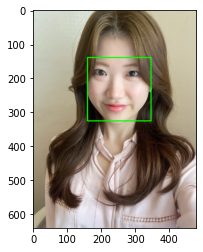

In [6]:
# 찾은 얼굴영역 좌표
#dlib.rectangles 는 dlib.rectangle 객체의 배열 형태
#dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지

## 3-4. 얼굴 랜드마크 face landmark
 
* face landmark localization 기술  
= 이목구비의 위치를 추론하는 것  
detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용
<br>

* 객체 내부의 점을 찾는 기술  
=바운딩 박스내의 68개의 점(랜드마크)  
=object keypoint estimation  
이 때 점의 개수는 데이터셋과 논문마다 다름  
<br>
* keypoint를 찾는 알고리즘  
1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측  
2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성  
<-우리는 1번으로 예제
<br>
* ibug 300-W 데이터셋  
Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공  
ibug 300-Wdms 68개 랜드마크  
학습 알고리즘은 regression tree의 앙상블 모델을 사용

-----
Dlib의 제공되는 모델을 사용  
공개되어 있는 weight file을 다운로드(위치는 root 디렉토리의 models 디렉토리)  
모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용  
해당과정을 터미널에 하면  
wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2  
mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models  
cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2


In [7]:
#모델파일을 저장하고, 저장한 landmark 모델을 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [8]:
list_landmarks = []

#dlib_rects = rectangles[[(159, 139) (345, 325)]] 박싱의 좌표였음
for dlib_rect in dlib_rects:
    #landmark_predictor : RGB 이미지와 dlib.rectangle을 입력받음 -> dlib.full_object_detection 를 반환
    points = landmark_predictor(img_rgb, dlib_rect)
    #parts() : 개별 위치에 접근
    # 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해줌
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    #list_points 는 tuple (x, y)=좌표 68개로 이루어진 리스트
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


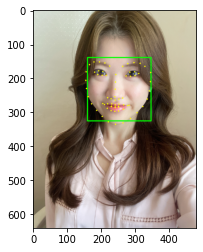

In [9]:
#68개의 튜플을 하나씩 가져오겠다
for landmark in list_landmarks:
    #튜플 값.. 중에 하나씩? 튜플로 가져오면 되면 for 하나만 써도 되는거 아닌가?
    #왜 for구문을 하나 더쓴거지? 이게 의미하는 바가 뭐지?
    for point in landmark:
        #2,-1은 뭐지..?
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3-5. 스티커 적용하기 : 왕관을 씌우자

>스티커 붙이는 법
랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 붙일거야  
방법 1)  코 중심을 기준으로 높이 x 이상에  
방법 2)  눈썹 위 n 픽셀 위에 스티커를 구현  

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에  
**비율로 계산**을 해줘야함

>비율 계산에 필요한 수치  
수치 1) 스티커위치  
수치 2) 스티커 크기

In [10]:
#코 중심의 좌표를 먼저 확인해보자
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    #왕관 사이즈 (리사이즈하고 있는 것)
    x = landmark[30][0] #68개 점 중 30번째에 코의 랜드마크 (x,y,w,h)값이 있음
    #이 와이값은 뭐야..? 왜이렇게 한거야? 왜 너비값을 빼지?
    #y= 랜드마크 튜플의 y좌표값 - 박싱한 너비값/2의 몫
    #설호님 피드백: 좌표계가 어느방향인지한번보면좋을것같아요:)
    #y좌표의 0값이 위에서부터 시작되네 !!
    y = landmark[30][1] - dlib_rect.width()// 2
    #여기에 사용된 width 너비길이는 얼굴 너비만큼의 크기로 가져온것
    #이걸 왕관의 높이와 너비에 적용
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
    #여기에서 나오는 xywh 값은 어디의 값이지?[(159, 139) (345, 325)]

(239, 254)
(x,y) : (239,161)
(w,h) : (187,187)


In [11]:
#준비해 둔 스티커 이미지를 읽어서 
#위에서 리사이즈 한것 적용하자
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [12]:
#원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
#이게 무슨말일까?
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#근데 여기서 음수가 나옴 : 음수는 기본 인물 이미지 크기에서 왕관이 벗어나서 출력됨을 의미함
#그래서 원본 이미지 범위 벗어난 스티커 부분 제거해줘야함

(x,y) : (146,-26)


In [13]:
#-y 크기만큼 스티커를 crop 
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(161, 187, 3)


In [14]:
#top 의 y 좌표는 원본 이미지의 경계 값으로 수정
#넘으면 크롭되는 한계값이 원본이미지의 경계값이 되므로
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (146,0)


In [15]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

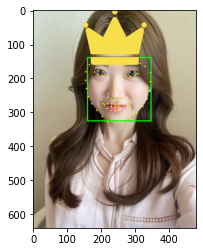

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

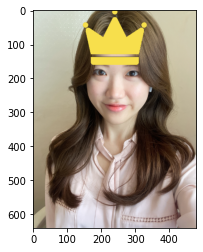

In [17]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

미세하게 왕관이 크롭된 것을 확인해볼 수 있음 !

## 3-6. 프로젝트: 고양이 수염 스티커 만들기

dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치 찾기

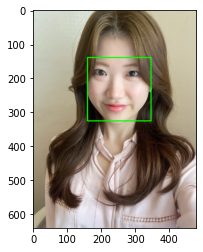

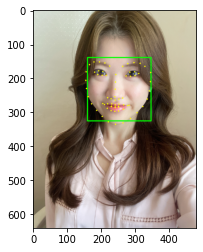

턱 좌표:  (156, 230)
눈 좌표:  (180, 182)
입 좌표:  (204, 274)
코 좌표:  (239, 254)
(x,y) : (239,254)
(w,h) : (187,187)
(187, 187, 3)


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480,640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
#plt.show()

# 색 보정 (BRG-> RGB)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
#plt.show()

#dlib을 활용해 hog detector(탐지기)를 선언
import dlib
detector_hog = dlib.get_frontal_face_detector() 

#detector를 이용해서 얼굴의 bounding box를 추출

#cvtColor(): opencv 의 bgr 이미지를 rgb로 변환 -> dlib에 rgb 이미지를 입력받을 수 있음
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

#dlib detector 는 dlib.rectangles 타입의 객체를 반환
dlib_rects = detector_hog(img_rgb, 1) 

#bounding box= 찾은 얼굴영역 좌표
#dlib.rectangles 는 dlib.rectangle 객체의 배열 형태
#dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함
#print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지

#모델파일을 저장하고, 저장한 landmark 모델을 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

#dlib_rects = rectangles[[(159, 139) (345, 325)]] 박싱의 좌표였음
for dlib_rect in dlib_rects:
    #landmark_predictor : RGB 이미지와 dlib.rectangle을 입력받음 -> dlib.full_object_detection 를 반환
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

#print(len(list_landmarks[0]))

#68개의 튜플을 하나씩 가져오겠다
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#턱,눈,입,코 중심의 좌표를 먼저 확인해보자
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("턱 좌표: ",landmark[2]) # 턱 인덱스:2
    print ("눈 좌표: ",landmark[36])
    print ("입 좌표: ",landmark[48]) 
    print ("코 좌표: ",landmark[30]) 
    #수염 사이즈 (리사이즈하고 있는 것)
    x = landmark[30][0] #68개 점 중 30번째에 코의 랜드마크 (x,y,w,h)값이 있음
    y = landmark[30][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    
    #여기에서 나오는 xywh 값은 어디의 값이지?[(159, 139) (345, 325)]
    
#준비해 둔 스티커 이미지를 읽어서 
#위에서 리사이즈 한것 적용하자
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
#dst = cv2.addWeighted(img_rgb,0.8,img_sticker,0.2,0)
#채널수가..다르네,, 다른 채널 수도 블렌딩 할 수 있는게 있지 않을까?
print (img_sticker.shape) #(187, 187, 3)


In [2]:
#원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
#위에서 계산한 스티커위치(x,y)를 이미지의 시작점에 맞게 재설정
refined_x = x - w // 2  # left
refined_y = y - h//2 
# top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#근데 여기서 음수가 나옴 : 음수는 기본 인물 이미지 크기에서 왕관이 벗어나서 출력됨을 의미함
#그래서 원본 이미지 범위 벗어난 스티커 부분 제거해줘야함

(x,y) : (146,161)


In [3]:
#-y 크기만큼 스티커를 crop 
#img_sticker = img_sticker[-refined_y:]
#print (img_sticker.shape)

In [4]:
#top 의 y 좌표는 원본 이미지의 경계 값으로 수정
#refined_y = 0
#print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

In [5]:
sticker_area = img_show[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

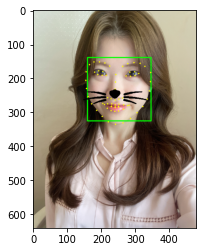

In [6]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

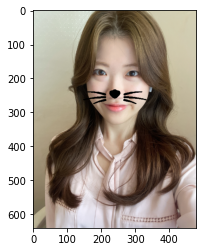

In [7]:
#스티커 부착 공간 
sticker_area = img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
#스티커 부착 공간을 대체할 공간을 쓰는 곳 = 그 공간을 대체하고 싶은 이미지의 위치
img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)
#np.where 부터는  조건 : !=0 :데이터가 있는 부분은 숫자 요소, 그리고 
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

평가문항	상세기준
1. 자기만의 카메라앱 기능 구현을 완수하였다.

원본에 스티커 사진이 정상적으로 합성되었다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.

정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.

얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.
얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
실행 속도가 중요할까요?
스티커앱을 만들 때 정확도가 얼마나 중요할까요?
https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c


### 1) 어두운 곳

##### 1. 사진 불러오기

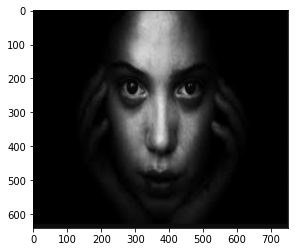

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/girl.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (750,640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
#plt.show()

# 색 보정 (BRG-> RGB)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) #rgb..? 흑백인데 rgb가 더 높은 차원이라 상관은 없겠지만;;
plt.show()


###### 2. 얼굴 영역  찾아서, 바운딩 박싱 삽입하기

rectangles[[(142, 143) (605, 605)]]


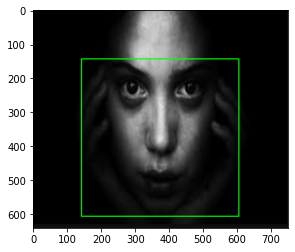

In [7]:
#dlib을 활용해 hog detector(탐지기)를 선언
#detector를 이용해서 얼굴의 bounding box를 추출

import dlib
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

dlib_rects = detector_hog(img_rgb, 1) 
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 3. 랜드 마크 

68


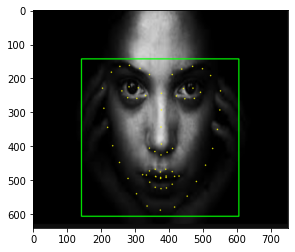

In [8]:
#landmark 모델을 저장하고 부르기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

#랜드 마크 추출하기
#dlib_rects = rectangles[[(170, 163) (232, 225)]]박싱의 좌표
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

#랜드마크 시각적 표현하기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 4. 스티커 적용하기 

In [9]:
#랜드마크의 턱,눈,코,입 좌표 확인해보자
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("턱 좌표: ",landmark[2]) # 턱 인덱스:2
    print ("눈 좌표: ",landmark[36])
    print ("입 좌표: ",landmark[48]) 
    print ("코 좌표: ",landmark[30]) 

    x = landmark[30][0] 
    y = landmark[30][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))


턱 좌표:  (219, 344)
눈 좌표:  (261, 237)
입 좌표:  (322, 483)
코 좌표:  (377, 393)
(x,y) : (377,393)
(w,h) : (464,464)


In [10]:
#스티커 불러와서 리사이즈
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(464, 464, 3)


In [12]:
#원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
refined_x = x - w // 2  # left
refined_y = y - h//2 
# top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#이미지 crop 따로 안함 -> 고양이 수염은 어차피 얼굴 중앙 위치하여서 크롭 위험 낮아서

(x,y) : (145,161)


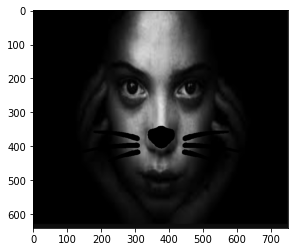

In [13]:
#스티커 부착하고, 랜드마크나 바운딩 박싱 시각적 표현 삭제

#스티커를 붙일 공간을 지정해둠
sticker_area = img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
#print(sticker_area)


#sticker_area에 스티커를 붙임 = 그 공간을 대체하고 싶은 이미지의 위치 지정
img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

#np.where 부터는  조건 : !=0 :데이터가 있는 부분은 숫자 요소, 0은 데이터가 없는 부분이니까 데이터 없는 부분 빼고
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

조명이 어둡지만 좋은 출력 결과를 얻음  
그러나 해당 과정에서, 코 좌표값 외 사용하지 않음 (턱,볼 등)  
즉 턱 볼등의 위치가 달라졌을 때 (얼굴이 기울어졌을때)  
수염 이미지가 반영되지 않을 것임  
해당 부분은 아래에서 도전  

### 2) 측면+ 멀리있는 사진 

##### 1. 사진 불러오기 + 색보정

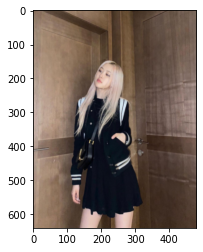

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rose.png'
img_bgr = cv2.imread(my_image_path)   
img_bgr = cv2.resize(img_bgr, (480,640))    
img_show = img_bgr.copy()     
#plt.imshow(img_bgr)
#plt.show()

# 색 보정 (BRG-> RGB)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

##### 2. 얼굴영역 찾아서, 바운딩 박싱 출력하기

rectangles[[(170, 163) (232, 225)]]


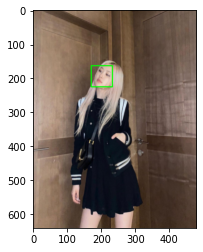

In [3]:
#얼굴 영역 좌표 찾기

import dlib
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

dlib_rects = detector_hog(img_rgb, 1) 
print(dlib_rects)   

#바운딩 박싱하기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 3. 랜드 마크 

68


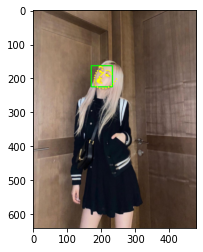

In [4]:
#landmark 모델을 저장하고 부르기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

#랜드 마크 추출하기
#dlib_rects = rectangles[[(170, 163) (232, 225)]]박싱의 좌표
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

#랜드마크 시각적 표현하기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

랜드마크는
얼굴이 멀리있어도, 기울어져도  
잘 인식하고 있음  

##### 4. 스티커 적용하기 

In [5]:
#랜드마크의 턱,눈,코,입 좌표 확인해보자
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ("턱 좌표: ",landmark[2]) # 턱 인덱스:2
    print ("눈 좌표: ",landmark[36])
    print ("입 좌표: ",landmark[48]) 
    print ("코 좌표: ",landmark[30]) 
#스티커 위치(x,y)
#스티커 크기(w,h)
#부착하고 싶은 스티커의 사이즈 정해보자
    x = landmark[30][0] 
    y = landmark[30][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))


턱 좌표:  (181, 191)
눈 좌표:  (194, 178)
입 좌표:  (188, 205)
코 좌표:  (197, 191)
(x,y) : (197,191)
(w,h) : (63,63)


(63, 63, 3)


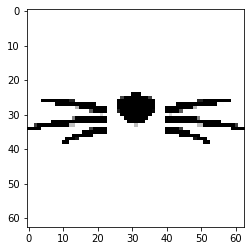

In [6]:
#스티커 불러와서, 위에 정해놓은 크기 계산식 이용해서 스티커 리사이즈(크기 적용)
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

plt.imshow(img_sticker)
plt.show()

#리사이즈된 이미지 size : (63, 63, 3)

In [6]:
#원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
#위에서 계산한 스티커위치(x,y)를 이미지의 시작점에 맞게 재설정
refined_x = x - w // 2  # left
refined_y = y - h//2 
# top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#이미지 crop 따로 안함 -> 고양이 수염은 어차피 얼굴 중앙 위치하여서 크롭 위험 낮아서

(x,y) : (166,160)


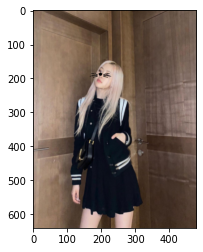

In [7]:
#스티커 부착하고, 랜드마크나 바운딩 박싱 시각적 표현 삭제

sticker_area = img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

앞서 말했듯이 코의 좌표만 반영했기 때문에  
볼,턱,눈의 위치에 대한 기울어진 변화들을 반영되지 않았음  
고양이 수염도 얼굴의 기울이, 측면에 따라 변화하도록 도전  

코 좌표 뿐 아니라 볼의 좌표를 읽어와서,   
코 좌표로는 코에 위치를 하고,  
볼의 두 좌표로는 수염이 기울어진 정도를 반영하려고 한다  

##### 스티커 이미지 기울이기 도전

In [7]:
import math

#기울어진 각도 계산하자
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
#abs() : 절대값 만들어줌
    x_change = abs(landmark[2][0] - landmark[14][0]) #삼각함수에서 a(밑변)의 길이
    y_change = abs(landmark[2][1] - landmark[14][1])
    radius = math.sqrt(x_change ** 2 +  y_change ** 2) #반지름 길이
    #1라디안 = 반지름 길이와 원둘레 길이가 같을때(호의 길이)의 각도
    #math.degrees() : 라디안 값을 인자로 받으면, 라디안 값을 각도 표현으로 변환
    #처음에 짠 코드 : degree = math.degrees(x_change/radius)
    #수학적 공식으로만 하는게 아니라, 파이썬에서 해당 인자를 넣으면 계산해주는 함수들이 있었음을 유의
    #degree = math.degrees(math.cos(x_change/radius))
    #위 코드랑 같은 의미인데, 오류가 계속 나서 이렇게도 한번 해봄
    degree = -math.degrees(math.acos(x_change / radius))
    print('degree: ', degree)
    
#스티커 위치,크기 계산하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
    #랜드마크 좌표 확인해보자
    print ("코 좌표: ",landmark[30]) 
    print ("왼쪽 볼 좌표: ",landmark[2]) #보는 사람 입장에서 왼쪽
    print ("오른쪽 볼 좌표: ",landmark[14]) 
#스티커 위치(x,y)
#스티커 크기(w,h)
#부착하고 싶은 스티커의 사이즈 정해보자
    x = landmark[30][0] - dlib_rect.width()//2
    y = landmark[30][1] - dlib_rect.width()//2 
    w = dlib_rect.width() 
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

degree:  -24.842389105455176
코 좌표:  (197, 191)
왼쪽 볼 좌표:  (181, 191)
오른쪽 볼 좌표:  (235, 216)
(x,y) : (166,160)
(w,h) : (63,63)


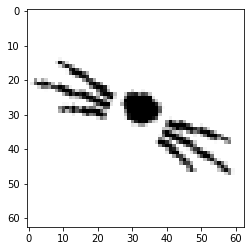

(x, y): (166, 160)


In [8]:
#스티커 불러와서, 위에 정해놓은 크기 계산식 이용해서 스티커 리사이즈(크기 적용)
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
sh, sw = img_sticker.shape[:-1]

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

#리사이즈된 스티커를 각도 적용해서 다시한번 리사이즈
#cv2.getRotationMatrix2D : 중앙점을 기준으로 회전 -> 이동변환 함수
#cv2.getRotationMatrix2D(center, angle, scale) = (중심좌표(x,y), 회전각도,추가 확대 비율) -> retval( 2x3 어파인 변환 행렬)
#어파인 변환 : 픽셀 값 유지하면서, 픽셀의 배치 구조를 변경 -> 평행성을 보존하면서 이미지 변환
tilt = cv2.getRotationMatrix2D((sh/2, sw/2), degree, 1)
#cv2.warpAffine(): 어파인 변환 함수 <- 어파인 변환 행렬을 함수에 입력해서 이동변환을 함
#cv2.warpAffine(src,M,dsize,borderValue) -> (입력 영상, 2x3 어파인 변환 행렬, 결과 영상 크기, 이동 변환을 했을 때 생기는 빈공간 채울 색)
# 더많은 인자를 받아올수 있는 함수인데, 이건 회고할때 첨부된 링크에서 확인 가능함 
#해당 함수 쓰면 결과로 dst = 결과 영상이 출력됨  borderValue=(0,0,0)
tilt_sticker = cv2.warpAffine(img_sticker, tilt, (w, h),borderValue=(255,255,255))
tilt_sticker = cv2.resize(tilt_sticker, (w, h))

plt.imshow(tilt_sticker)
plt.show()


refined_x = x
refined_y = y
print('(x, y): (%d, %d)'%(refined_x, refined_y))

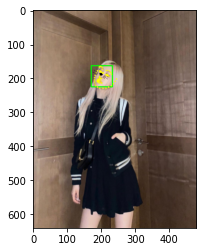

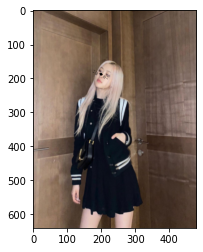

In [9]:
#스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(tilt_sticker!=0, sticker_area,tilt_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
#스티커 부착하고, 랜드마크나 바운딩 박싱 시각적 표현 삭제

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(tilt_sticker!=0, sticker_area,tilt_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

꺅!!!! 드디어 성공 !!!!! 기울어졌다 ㅠㅠㅠㅠ!!!  

### 3) 다수

##### 1. 사진 불러오기 + 색보정

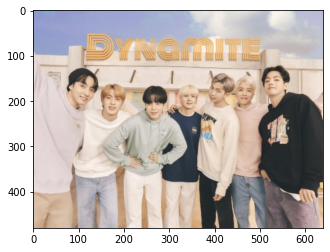

In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/bts.png'
img_bgr = cv2.imread(my_image_path)   
img_bgr = cv2.resize(img_bgr, (640,480))    
img_show = img_bgr.copy()     
#plt.imshow(img_bgr)
#plt.show()

# 색 보정 (BRG-> RGB)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

##### 2. 얼굴영역 찾아서, 바운딩 박싱 출력하기

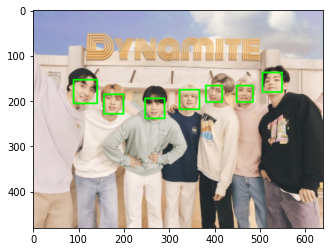

In [40]:
#얼굴 영역 좌표 찾기

import dlib
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

dlib_rects = detector_hog(img_rgb, 1) 
#print(dlib_rects)   

#바운딩 박싱하기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 3. 랜드마크

68


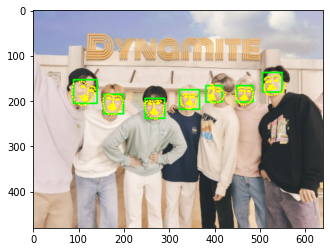

In [41]:
#landmark 모델을 저장하고 부르기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

#랜드 마크 추출하기
#dlib_rects = rectangles[[(170, 163) (232, 225)]]박싱의 좌표
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

#랜드마크 시각적 표현하기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

##### 4. 스티커 적용하기

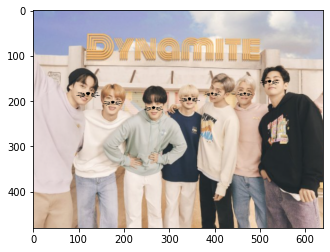

In [50]:
#랜드마크의 턱,눈,코,입 좌표 확인해보자
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #print ("턱 좌표: ",landmark[2]) # 턱 인덱스:2
    #print ("눈 좌표: ",landmark[36])
    #print ("입 좌표: ",landmark[48]) 
    #print ("코 좌표: ",landmark[30]) 

    x = landmark[30][0] 
    y = landmark[30][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    #print ('(x,y) : (%d,%d)'%(x,y))
    #print ('(w,h) : (%d,%d)'%(w,h))
    
    #스티커 불러와서 리사이즈
    import os
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    #print (img_sticker.shape)
    
    #원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정
    refined_x = x - w // 2  # left
    refined_y = y - h//2 
    # top
    #print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

    #이미지 crop 따로 안함 -> 고양이 수염은 어차피 얼굴 중앙 위치하여서 크롭 위험 낮아서
    
    sticker_area = img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:img_sticker.shape[0]+refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

**1. 스티커 배경 제거**  
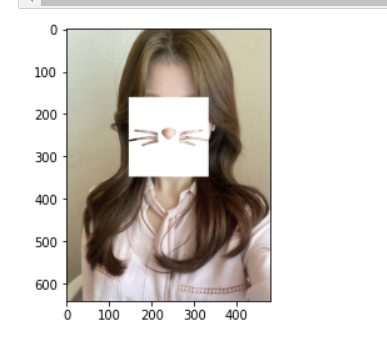

위 이미지와 같이 고양이 수염을 처음에 출력할 때  
수염이 그려진 (검정색 부분)은 이미지가 사라져서 인물이 보였고,  
수염의 이미지가 차지하는 공간은 배경이 흰색이 되어 출력되었었다  


그래서 스티커를 적용하는 코드에서 조건을 수정해줬다 
> 기존코드 : np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)  
  수정코드 : np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)  
    
**논리연산자 ==를 !=로 수정함**  
이렇게 수정한 이유를 살펴보면  
이미지 데이터를 보면 이미지가 있는 부분은 숫자 데이터가 들어가있고,  
이미지가 없는 부분은 0데이터가 들어가있음  
그래서 출력되는 이미지는 **0이 아닌 데이터를 출력**할거라고 조건을 설정 

**2.기울어진 각도 반영해서 스티커 부착하기**  
얼굴의 기울어진 정도를 반영하고자 할때 
처음엔 dilb 라이브러리 내에서  
제공하고 있는 기능이 있을거라고 생각했는데  
찾지 못했다. 

이 이후에는 두 점의 기울기를 구하면 각도를 구할 수 있지 않을까  
생각이 들었다  
그래서 두점의 기울기를 구하려고 했는데  
생각해보니, 두점을 잇는 직선의 기울기가 아니라  
두점을 잇는 방정식과 x축과의 각도를 구하는 것이라는 생각이 들었다 

그래서 삼각함수를 이용해보려고 했음 
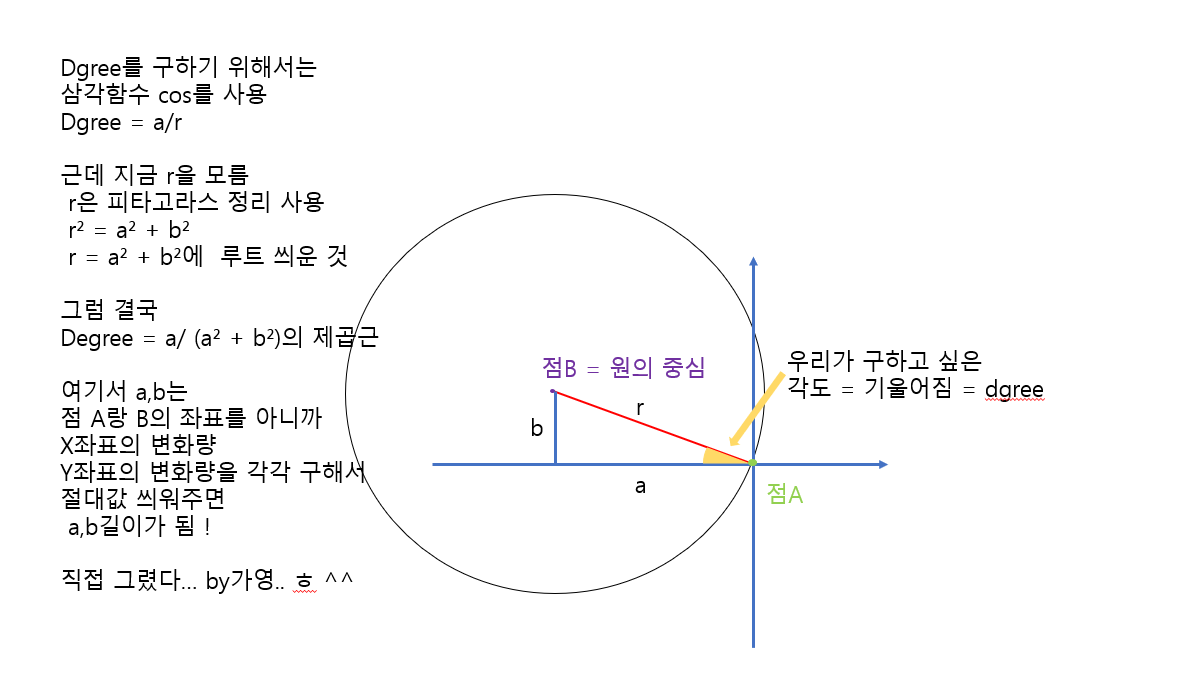

라디안에 대한 개념 참고 블로그  
https://blockdmask.tistory.com/529

각도는 그럼 완료되었고,  
또하나의 문제는 구한 각도를 이미지에 반영시키는 것  

이미지 반영을 위해 스티커 resize 부분에 코드를 작성  
(처음엔 이미지가 부착되는 좌표 설정 하는 부분에서 작성했었음 ;;  
그때는 논리가 그게 맞다고 생각했었으니까 그랬을텐데..  
resize에서 해야된다는걸 알게되니까, 아 맞네 당연한거였네 싶어져서  
어떤 생각으로 거기에 처음에 썼는지 기억안남...ㅎ)

스티커 이미지 회전을 위해서 처음엔 opencv의 rotate함수를 접함  
https://bskyvision.com/921  
근데 내가 각도를 지정해서.. 하는 함수는 안보임  
더 검색하다가  
중앙점을 기준으로 이미지가 회전되는 함수 : cv.2getRotationMatrix2D 발견
https://deep-learning-study.tistory.com/199

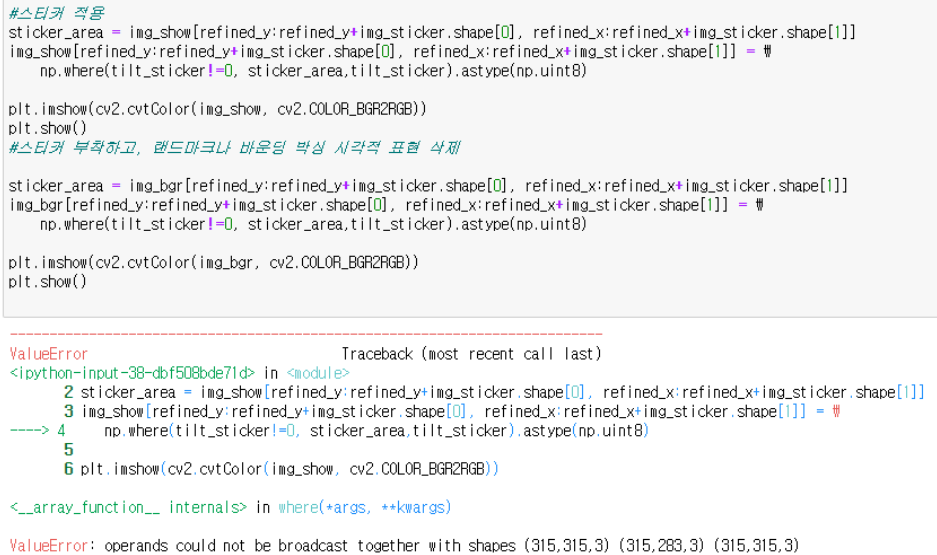
<br>
함수를 쓰고 적용해봤지만, 계속 차원 에러가 남... 
이유는 cv.2getRotationMatrix2D을 쓸 때 중심축을  
전체 이미지 (여기서는 인물이미지)의 좌표(코 랜드마크)를 중심으로 했기 때문인것 같음  
중심축을 스티커 이미지의 중심 축을 해야함  
그래서 스티커 이미니.shape을 에서 축의 값을 받아오고자 도전 -> 기울어진것 확인 완료!!!!!!!  
<br>

제출 5분 전이라 이제 이미지 좌표 값을 조절해주면 될 것 같은데  
이건 금방하니까 ㅎㅎ
<br>

제출 3분전 완전히 적용 !!!!!  
마지막 방탄 단체 사진은 일단 딥러닝 예습하고  
내일 도전해보기로 !